# Information Retrieval I #
## Assignment 2: retrieval models [100 points + 10 bonus points] ##

Name: Klaas Schuijtemaker

Student nr.: 11163119

Date: 26 jan. 2017

In [1]:
import logging
import sys

def write_run(model_name, subject_id, object_assesments, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - topic_id
        - object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    if not object_assesments:
        logging.warning('Received empty ranking for %s; ignoring.',
                        subject_id)
        print(model_name,subject_id,object_assesments,out_f)

        return

    # Probe types, to make sure everything goes alright.
    # assert isinstance(object_assesments[0][0], float) or \
    #     isinstance(object_assesments[0][0], np.float32)
    assert isinstance(object_assesments[0][1], str) or \
        isinstance(object_assesments[0][1], bytes)

    if not skip_sorting:
        object_assesments = sorted(object_assesments, reverse=True)

    if max_objects_per_query < sys.maxsize:
        object_assesments = object_assesments[:max_objects_per_query]

    if isinstance(subject_id, bytes):
        subject_id = subject_id.decode('utf8')

    for rank, (relevance, object_id) in enumerate(object_assesments):
        if isinstance(object_id, bytes):
            object_id = object_id.decode('utf8')

        out_f.write(
            '{subject} Q0 {object} {rank} {relevance} '
            '{model_name}\n'.format(
                subject=subject_id,
                object=object_id,
                rank=rank + 1,
                relevance=relevance,
                model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    subject_id='Q1',
    object_assesments=((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


### Task 1: Implement and compare lexical IR methods [45 points] ### 

#### Implementation of all IR methods

In [10]:
import pyndri
import collections
import io
import logging
import sys

# Load documents
index = pyndri.Index('index/')
token2id, id2token, id2df = index.get_dictionary()
id2tf = index.get_term_frequencies()

# usefull definitions
n = index.document_count() # total amount of documents
get_tf = lambda token_id, document: sum(token_id == word for word in document[1]) # term frequency
get_df = lambda token_id: id2df[token_id] # document frequency
get_idf = lambda token_id: math.log(n / get_df(token_id)) # inverse document frequency
get_l = lambda document_id: max(0.001, index.document_length(document_id)) # total amount of words in document
get_lu = lambda document: len(set(document[1])) # total amount of unique words in document

l_tot = 0 # |C| total amount of words in collection
for int_document_id in range(index.document_base(), index.maximum_document()):
    l_tot += get_l(int_document_id)
l_avg = l_tot / n # average amount of words in collection

# TF-IDF
def score_tf_idf(query_id_tokens, document_id):
    document = index.document(document_id)
    score = 0
    for token_id in query_id_tokens:
        score += math.log(1+get_tf(token_id, document)) * get_idf(token_id)
    return (score, document[0])

# BM25
def score_bm25(query_id_tokens, document_id, k1=1.2, b=0.75):
    document = index.document(document_id)
    a = k1 + 1
    c = k1 * ((1-b) + b*(get_l(document_id) / l_avg))
    score = 0
    for token_id in query_id_tokens:
        tf = get_tf(token_id, document)
        score += a * tf / (c + tf) * get_idf(token_id)
    return (score, document[0])

# Language Model with Jelinek-Mercer smoothing
def score_jelinek_mercer(query_id_tokens, document_id, lamb=0.6):
    document = index.document(document_id)
    score = 1
    for token_id in query_id_tokens:
        score *= lamb * get_tf(token_id, document) / get_l(document_id) + (1-lamb) * id2tf[token_id] / l_tot
    return (score, document[0])

# Language Model with Dirichlet Prior smooting
def score_dirichlet_prior(query_id_tokens, document_id, mu=1250):
    document = index.document(document_id)
    a = get_l(document_id) / (get_l(document_id) + mu)
    b = mu / (mu+get_l(document_id))
    score = 1
    for token_id in query_id_tokens:
        score *= a*get_tf(token_id, document)/get_l(document_id) + b*id2tf[token_id]/l_tot 
    return (score, document[0])

# Language Model Absolute discounting smoothing
def score_absolute_discounting(query_id_tokens, document_id, delta=0.9):
    document = index.document(document_id)
    b = delta*get_lu(document)/get_l(document_id)
    score = 1
    for token_id in query_id_tokens:
        score *= max(get_tf(token_id, document)-delta,0)/get_l(document_id) + b*id2tf[token_id]/l_tot
    return (score, document[0])

# all kernels
def gaussian_kernel(i, j, sigma):
    return math.exp(-(i-j)**2 / 2*sigma**2)

def triangle_kernel(i, j, sigma):
    if abs(i-j) <= sigma:
        return 1 - abs(i-j)/sigma
    else:
        return 0

def cosine_kernel(i, j, sigma):
    if abs(i-j) <= sigma:
        return 0.5 * (1+math.cos(abs(i-j)*math.pi/sigma))
    else:
        return 0

def circle_kernel(i, j, sigma):
    if abs(i-j) <= sigma:
        return math.sqrt(1 - (abs(i-j)/sigma)**2)
    else:
        return 0

def passage_kernel(i, j, sigma):
    if abs(i-j) <= sigma:
        return 1
    else:
        return 0

# Positional Language Model (way too slow)
def score_plm(query_id_tokens, document_id, kernel_method, mu=1000, sigma=50):
    document = index.document(document_id)
    sqd = 0 # S(Q,D)
    for i, i_word in enumerate(document[1]):
        sqdi = 0 # S(Q,D,i)
        for v_word in id2token.keys():
            c_wi = 0 # c'(w,i)
            for j, j_word in enumerate(document[1]):
                cwi = (i_word == j_word) # c(w,i)
                c_wi += cwi * kernel_method(i,j,sigma)
            pwc = id2tf[v_word] / l_tot # p(w|C)
            zi = sum(kernel_method(i,j,sigma) for j in range(len(document[1]))) # Zi = sum(c'(w,i))
            pwdi = (c_wi+mu*pwc) / (zi+mu) # p(w|D,i)
            pwq = 1 # p(w|Q)
            for token_id in query_id_tokens:
                pwq *= get_tf(token_id, document) / get_l(document_id)
            if pwq/pwdi != 0:
                sqdi -= pwq * math.log(pwq/pwdi)
        sqd = max(sqd, sqdi) 
    return (sqd, document[0])

#### Load queries

In [11]:
queries = []
for line in open('ap_88_89/topics_title'):
    cell = line.split(';')
    query_id = int(cell[0])
    query = cell[1]
    query_tokens = index.tokenize(query)
    query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
    query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
    queries += [(query_id, query_id_tokens)]

#### Run experiments
A complete run through all the experiments took too much time. Therefore, the number of documents were decreased to 2000.
However, the Positional Language Model was still way too slow. So we decided not to test the PLM. Nevertheless, it's implementation should be correct.

In [12]:
import random
import subprocess

# scale down. decrease number of documents
sample_size = 5000
document_sample = random.sample(range(index.document_base(), index.maximum_document()), sample_size)

# run experiment and save results
def run_experiment(ir_name, ir_method, ir_args=[None]):
    for ir_arg in ir_args:
        
        if ir_arg == None:
            file_name = ir_name + '.run'
        else:
            file_name = ir_name + '_' + str(ir_arg) + '.run'
            
        with open(file_name, 'w'): pass
        with open(file_name, 'a') as run_file:

            for query_id, query_id_tokens in queries:

                assesments = []
                for int_document_id in document_sample:
                    
                    if ir_arg == None:
                        assesment = ir_method(query_id_tokens, int_document_id)
                    else:
                        assesment = ir_method(query_id_tokens, int_document_id, ir_arg)
                    
                    if assesment[0] > 0:
                        assesments += [assesment]
                
                if len(assesments) > 0:
                    write_run('_', query_id, tuple(assesments), run_file, 1000)
        
        print('Finished:', file_name)


# run all experiments
run_experiment('TF-IDF', score_tf_idf)
run_experiment('BM25', score_bm25)
run_experiment('Jelinek-Mercer', score_jelinek_mercer, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
run_experiment('Dirichlet Prior', score_dirichlet_prior, [500, 1000, 1500, 2000])
run_experiment('Absolute discounting', score_absolute_discounting, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
#run_experiment('PLM', score_plm, [gaussian_kernel,triangle_kernel,cosine_kernel,circle_kernel,passage_kernel])


KeyboardInterrupt: 

#### Plot hyper parameter values

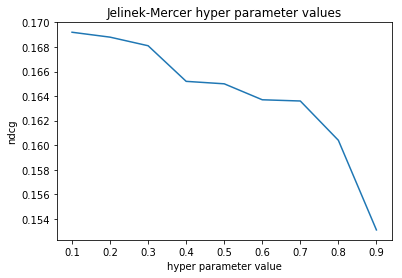

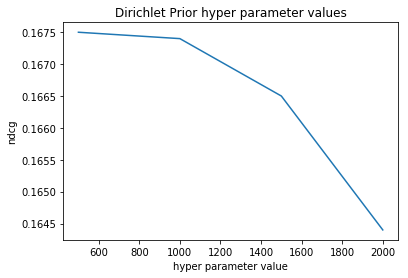

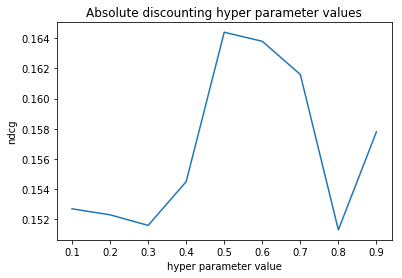

(None,)

In [15]:
import matplotlib.pyplot as plt
import subprocess

def plot_hyper_parameter_values(ir_name, ir_args):
    
    ndcgs = []
    for ir_arg in ir_args:
        if ir_arg == None:
            file_name = ir_name + '.run'
        else:
            file_name = ir_name + '_' + str(ir_arg) + '.run'
        ev_methods = '(ndcg_cut_10\W+all)'
        qrel_set = 'ap_88_89/qrel_validation'
        cmd = 'trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
        ndcg = float(subprocess.check_output(cmd, shell=True).decode('utf-8').split('\t')[2].strip())
        ndcgs += [ndcg]
    
    plt.title(ir_name + ' hyper parameter values')
    plt.plot(ir_args, ndcgs)
    plt.xlabel('hyper parameter value')
    plt.ylabel('ndcg')
    plt.show()

# Plot all language model hyper parameters
plot_hyper_parameter_values('Jelinek-Mercer', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
plot_hyper_parameter_values('Dirichlet Prior', [500, 1000, 1500, 2000]),
plot_hyper_parameter_values('Absolute discounting', [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
#plot_hyper_parameter_values('PLM', [gaussian_kernel,triangle_kernel,cosine_kernel,circle_kernel,passage_kernel]),


#### Evaluate IR methods

In [16]:
def print_eval_ir_method(ir_name, ir_arg=None):
    if ir_arg == None:
        file_name = ir_name + '.run'
    else:
        file_name = ir_name + '_' + str(ir_arg) + '.run'

    ev_methods = '(ndcg_cut_10\W+all)|(map_cut_1000\W+all)|(^P_5\W+all)|(recall_1000\W+all)'
    qrel_set = 'ap_88_89/qrel_test'
    cmd = 'trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
    
    print(file_name + ':')
    print(subprocess.check_output(cmd, shell=True).decode('utf-8'))
    print('\n')

print_eval_ir_method('TF-IDF')
print_eval_ir_method('BM25')
print_eval_ir_method('Jelinek-Mercer', 0.1)
print_eval_ir_method('Dirichlet Prior', 500)
print_eval_ir_method('Absolute discounting', 0.5)
#print_eval_ir_method('PLM', gaussian_kernel)

TF-IDF.run:
P_5                   	all	0.1633
recall_1000           	all	0.0290
ndcg_cut_10           	all	0.1462
map_cut_1000          	all	0.0133



BM25.run:
P_5                   	all	0.1600
recall_1000           	all	0.0290
ndcg_cut_10           	all	0.1436
map_cut_1000          	all	0.0132



Jelinek-Mercer_0.1.run:
P_5                   	all	0.1533
recall_1000           	all	0.0298
ndcg_cut_10           	all	0.1369
map_cut_1000          	all	0.0127



Dirichlet Prior_500.run:
P_5                   	all	0.1583
recall_1000           	all	0.0281
ndcg_cut_10           	all	0.1425
map_cut_1000          	all	0.0135



Absolute discounting_0.5.run:
P_5                   	all	0.1567
recall_1000           	all	0.0291
ndcg_cut_10           	all	0.1408
map_cut_1000          	all	0.0134





#### Prove significance
We cannot find any siginifcantly better IR method. This is because the number of documents were decreased to make the experiment feasable. =(

In [17]:
import subprocess
from scipy import stats

# 
alpha = 0.10

# get Mean Average Precision per query of an IR method
def get_maps(ir_name, ir_arg=None):
    if ir_arg == None:
        file_name = ir_name + '.run'
    else:
        file_name = ir_name + '_' + str(ir_arg) + '.run'
    
    ev_methods = '(map_cut_10\W+[0-9])'
    qrel_set = 'ap_88_89/qrel_test'
    cmd = 'trec_eval -m all_trec -q "' + qrel_set + '" "' + file_name + '" | grep -E "' + ev_methods + '"'
    results = subprocess.check_output(cmd, shell=True).decode('utf-8').split('\n')
    return [float(result.split('\t')[2]) for result in results if len(result) > 0]

# Do t-test and print significance
def print_significance(ir_name1, ir_arg1, ir_name2, ir_arg2, alpha, k):
    
    ttest = stats.ttest_rel(get_maps(ir_name1, ir_arg=ir_arg1), get_maps(ir_name2, ir_arg=ir_arg2))
    
    # Bonferroni correction
    alpha_per_comparison = alpha / k
    
    if ttest.pvalue > alpha_per_comparison:
        print(ir_name1 + ' == ' + ir_name2, '\t\tp-value:', ttest.pvalue)
    elif ttest.statistic < 0:
        print(ir_name1 + ' < ' + ir_name2, '\t\tp-value:', ttest.pvalue)
    else:
        print(ir_name2 + ' < ' + ir_name1, '\t\tp-value:', ttest.pvalue)

# Define IR methods for t-test
ir_methods = (
    ('TF-IDF', None),
    ('BM25', None),
    ('Jelinek-Mercer', 0.1),
    ('Dirichlet Prior', 500),
    ('Absolute discounting', 0.5)
)

# Do tests
print('No significant results were found due to scalling down the experiment.')
for ir_name1, ir_arg1 in ir_methods:
    for ir_name2, ir_arg2 in ir_methods:
        if ir_name1 == ir_name2:
            break
        print_significance(ir_name1, ir_arg1, ir_name2, ir_arg2, alpha, 4)


No significant results were found due to scalling down the experiment.
BM25 == TF-IDF 		p-value: 0.891279909642
Jelinek-Mercer == TF-IDF 		p-value: 0.606203182163
Jelinek-Mercer == BM25 		p-value: 0.398933647771
Dirichlet Prior == TF-IDF 		p-value: 0.692737281815
Dirichlet Prior == BM25 		p-value: 0.538950596507
Dirichlet Prior == Jelinek-Mercer 		p-value: 0.248583470169
Absolute discounting == TF-IDF 		p-value: 0.719894751335
Absolute discounting == BM25 		p-value: 0.573940195191
Absolute discounting == Jelinek-Mercer 		p-value: 0.248319064373
Absolute discounting == Dirichlet Prior 		p-value: 0.983572913448


### Task 2: Latent Semantic Models (LSMs) [25 points + 10 bonus points] ###

#### Initialize word2vec

In [18]:
import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys

word2vec_init = gensim.models.Word2Vec(
    size=300,    # Embedding size
    window=5,    # One-sided window size
    sg=True,     # Skip-gram.
    min_count=5, # Minimum word frequency.
    sample=1e-3, # Sub-sample threshold.
    hs=False,    # Hierarchical softmax.
    negative=10, # Number of negative examples.
    iter=1,      # Number of iterations.
    workers=8,   # Number of workers.
)

# limit number of docs
max_documents = 5000
class IndriSentences(pyndri.compat.IndriSentences):
    def _maximum_document(self):
        return min(max_documents + self.index.document_base(), self.index.maximum_document())

#
dictionary = pyndri.extract_dictionary(index)
sentences = IndriSentences(index, dictionary)

# Build vocab.
word2vec_init.build_vocab(sentences, trim_rule=None)
model = word2vec_init


#### some usefull defenitions

In [19]:
import numpy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import mutual_info_score # (is equivalent to KL Divergence)

# token-ids to word-vec
def word2vec_representation(id_tokens):
    representation = [id2token[token_id] for token_id in id_tokens if token_id > 0]
    representation = [model[token] for token in representation if token in model]
    return representation

# returns similarity between word-vecs
def cos_similarity(r1, r2):
    r1 = numpy.reshape(r1, (1, -1))
    r2 = numpy.reshape(r2, (1, -1))
    pad = r1.shape[1] - r2.shape[1]
    if pad > 0:
        r2 = numpy.pad(r2,((0,0),(0,pad)), 'constant')
    elif pad < 0:
        r1 = numpy.pad(r1,((0,0),(0,-pad)), 'constant')
    return cosine_similarity(r2, r1)[0][0]
    #return mutual_info_score(query_representation[0], doc_representation[0])

class ZeroDict(dict):
    def __missing__(self, key):
        return 0
    
class NestedDict(dict):
    def __missing__(self, key):
        value = self[key] = ZeroDict()
        return value

#### Run word2vec experiment
Should run the experiment and save the result to 'word2vec.run'. But something is wrong. Instead of returing the updated query model, it returns the original query model. This might be due to the scale down. The original experiment was to CPU extensive. Therefore the number of words used for the estimated query model, was limited.

In [ ]:
file_name = 'word2vec.run'
lamb = 0.5
alpha = 0.5

with open(file_name, 'w'): pass
with open(file_name, 'a') as run_file:
    
    query_id = '51'
    n = 1000
    ranking = [0] * n
    
    for line in open('Dirichlet Prior_500.run'):

        cell = line.split()
        if query_id != cell[0]:
            
            # Generative Mixture Model
            
            ## fill words & cwd_map
            words = []             # every w
            cwd_map = NestedDict() # c(w;d_n)     for every n and every w
            for rank, doc_id in enumerate(ranking):
                doc = index.document(doc_id)
                doc_words = [token_id for token_id in doc[1] if token_id > 0]
                words += doc_words
                for word in doc_words:
                    cwd_map[rank][word] = get_tf(word, doc)
            words = set(words[:20]) # LIMIT! <- CAUSE OF PROBLEM?
            
            ## fill pwc_map
            pwc_map = ZeroDict()   # p(w|C)       for every w
            for word in words:
                 pwc_map[word] = id2tf[word] / l_tot
            
            
            ## EM algorithm
            pwf_map = NestedDict() # p^(n)(w|0_F) for every n and every w
            tnw_map = NestedDict() # t^(n)(w)     for every n and every w
            
            for word in words:
                tnw_map[-1][word] = 1
            
            for rank in range(n):
                for word in words:
                    if tnw_map[rank-1][word] != 0:
                        t1 = sum(cwd_map[j][word] * tnw_map[rank-1][word] for j in range(n))
                        if t1 != 0:
                            t2 = sum(sum(cwd_map[j][w] * tnw_map[rank-1][w] for w in words) for j in range(n))
                            if t2 != 0:
                                pwf_map[rank][word] = t1 / t2
                                tnw_map[rank][word] = (1-lamb)*pwf_map[rank][word] / ((1-lamb)*pwf_map[rank][word]+lamb*pwc_map[word])
                                #print(t1 / t2)
                if rank % 20 == 0:
                    print(rank)
            
            ## fill pwF
            pwF_map = ZeroDict() # p(w|0_F)
            for word in words:
                pwF_map[word] = 1
                for i in range(n):
                    pwF_map[word] *= pwf_map[i][word]
            
            # update query model
            pwq_map = ZeroDict() # p(q|0_F)
            
            ## estimated query model
            for word,p in pwF_map.items():
                pwq_map[word] = p * alpha
            
            ## original query model 
            query = queries[int(query_id)]
            for word in query[1]:
                pwq_map[word] = 1 * (1-alpha)
            
            ## print test
            print('Original query:', [id2token[word] for word in query[1]])
            for word, p in sorted(zip(pwq_map.keys(), pwq_map.values()), key=lambda x: x[0]):
                if p > 0:
                    print(id2token[word] + ':', p)
            
            # get query representation
            query_representation = [model[id2token[word]] * p for word, p in pwq_map.items() if id2token[word] in model and p > 0]
            
            # score with cosine-similarity
            assesments = []
            for doc_id in ranking:
                doc = index.document(doc_id)
                doc_representation = word2vec_representation(doc[1])
                score = cos_similarity(doc_representation, query_representation)
                assesments += [(score, doc[0])]
            
            # save results
            write_run('_', query_id, tuple(assesments), run_file, 1000)

            #
            print('finished query:', query_id)
            query_id = cell[0]
            
        # fill ranking
        doc_id = index.document_ids([cell[2]])[0][1]
        rank = int(cell[3]) - 1
        ranking[rank] = doc_id
        